# Demo of a weighted generative model
An example weighted generative model implementation

In [1]:
# weighted_genreative_model conda environment
# import requirements
import os
import numpy as np
import scipy
import networkx as nx
import bct as bctpy
import matplotlib.pyplot as plt
import pylab
import copy
import random
from mpl_toolkits.mplot3d import Axes3D
import brainconn as bct

In [2]:
# set network variables
nnode = 60 # number of nodes
xnode = 10 # x axis
ynode = 2 # y axis
znode = 3 # z axis
# compute inputs
Atgt = np.tril(np.random.randint(0,100,(nnode,nnode)),-1)
Atgt = (Atgt+Atgt.T)
threshold, upper, lower = 96,1,0
Atgt = np.where(Atgt>threshold,upper,lower)
Aseed = np.zeros((nnode,nnode)) # seed the seed as a random edge that exists
#ind = np.argwhere(Atgt)
#indedge = ind[random.randrange(len(ind)),:]
#Aseed[indedge[0],indedge[1]] = Aseed[indedge[1],indedge[0]] = 1
x = np.arange(xnode) # set the x axis
y = np.arange(ynode) # set the y axis
z = np.arange(znode) # set the z axis
c = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3) # placed in a grid
d = scipy.spatial.distance.pdist(c)
D = scipy.spatial.distance.squareform(d) # euclidean distance matrix
m = int(np.size(np.where(Atgt.flat))/2) # number of connections
eta = np.array([-2]) # eta parameter
gamma = np.array([.5]) # gamma parameter
model_type = 'matching' # generative model
model_var = 'powerlaw' # wiring equation
epsilon = 1e-6

Text(0, 0.5, 'Node')

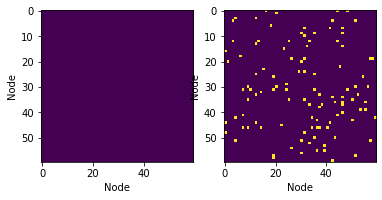

In [3]:
# visualise the seed matrix
subax1 = plt.subplot(121)
plt.imshow(Aseed)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the target matrix
subax1 = plt.subplot(122)
plt.imshow(Atgt)
plt.xlabel('Node')
plt.ylabel('Node')

In [4]:
# run and example binary generative model
b = bct.generative.generative_model(Aseed, 
                     D, 
                     m, 
                     eta, 
                     gamma, 
                     model_type='matching',
                     model_var='powerlaw', 
                     epsilon=1e-6, 
                     copy=True)

/home/da04/.conda/envs/weighted_generative_model/lib/python3.7/site-packages/brainconn/generative/generative.py:279: RuntimeWarning: divide by zero encountered in power
  Fd = D**eta


(54, 54)

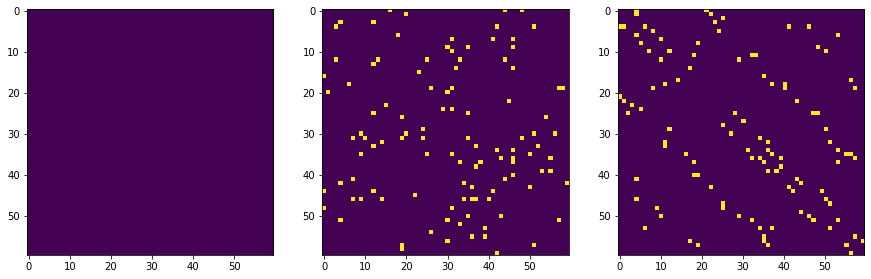

In [5]:
# visualise the binary model
# plot the outcome
plt.figure(figsize=(15,5))
subax1 = plt.subplot(131)
plt.imshow(Aseed)
subax2 = plt.subplot(132)
plt.imshow(Atgt)
subax2 = plt.subplot(133)
plt.imshow(b)
# display the number of edges in target and final network as a sanity check
m,np.size(np.where(b.flat))//2 # number of connections

In [26]:
# initialise the weighted generative model
alpha = 100 # set the update rate
nopt = 1000 # set number of gradient jumps
mi, _, _ = bct.similarity.matching_ind(Aseed) # matching index of the seed
Kseed = mi + mi.T # value matrix of the seed
Kseed += epsilon # add epsilon
mseed = np.size(np.where(Aseed.flat))//2 # compute the number of edges in the seed

In [27]:
# run a single example
if type(model_var) == tuple:
    mv1, mv2 = model_var
else:
    mv1, mv2 = model_var, model_var

if mv1 in ('powerlaw', 'power_law'):
    Fd = D**eta
elif mv1 in ('exponential',):
    Fd = np.exp(eta*D)

if mv2 in ('powerlaw', 'power_law'):
    Fk = Kseed**gamma
elif mv2 in ('exponential',):
    Fk = np.exp(gamma*Kseed)
Ffseed = Fd * Fk * np.logical_not(Aseed)
u, v = np.where(np.triu(np.ones((nnode, nnode)), 1)) # get all row column combinations
A = copy.deepcopy(Aseed) # set the new variable
K = copy.deepcopy(Kseed) # set the new variable
Ff = copy.deepcopy(Ffseed) # set the new variable
for ii in range(mseed,m):
    C = np.append(0, np.cumsum(Ff[u, v]))
    r = np.sum(np.random.random()*C[-1] >= C)
    uu = u[r]
    vv = v[r]
    A[uu, vv] = A[vv, uu] = 1
    updateuu, = np.where(np.inner(A, A[:, uu]))
    np.delete(updateuu, np.where(updateuu == uu))
    np.delete(updateuu, np.where(updateuu == vv))
    c1 = np.append(A[:, uu], A[uu, :])
    for i in range(len(updateuu)):
        j = updateuu[i]
        c2 = np.append(A[:, j], A[j, :])

        use = np.logical_or(c1, c2)
        use[uu] = use[uu+nnode] = use[j] = use[j+nnode] = 0
        ncon = np.sum(c1[use]) + np.sum(c2[use])
        if ncon == 0:
            K[uu, j] = K[j, uu] = epsilon
        else:
            K[uu, j] = K[j, uu] = (2 / ncon * np.sum(np.logical_and(c1[use],c2[use])) +epsilon)
    updatevv, = np.where(np.inner(A, A[:, vv]))
    np.delete(updatevv, np.where(updatevv == uu))
    np.delete(updatevv, np.where(updatevv == vv))
    c1 = np.append(A[:, vv], A[vv, :])
    
    for i in range(len(updatevv)):
        j = updatevv[i]
        c2 = np.append(A[:, j], A[j, :])

        use = np.logical_or(c1, c2)
        use[vv] = use[vv+nnode] = use[j] = use[j+nnode] = 0
        ncon = np.sum(c1[use]) + np.sum(c2[use])
        if ncon == 0:
            K[vv, j] = K[j, vv] = epsilon
        else:
            K[vv, j] = K[j, vv] = (2 / ncon * np.sum(np.logical_and(c1[use],c2[use])) +epsilon)

    Fffinal = Fd * Fk * np.logical_not(A)
    # add an optimisation step
    com = scipy.linalg.expm(A) # compute communicability
    sumcom = np.sum(com) # sum communicability
    for j in range(nopt): # nopt number of optimisation steps
        grad = np.gradient(A,sumcom) # compute the gradient
        W = A + alpha*grad[1] # walk down the gradient
        W[W<0] = 0 # limit to optimise positive weights

/home/da04/.conda/envs/weighted_generative_model/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in power
  


(54, 53)

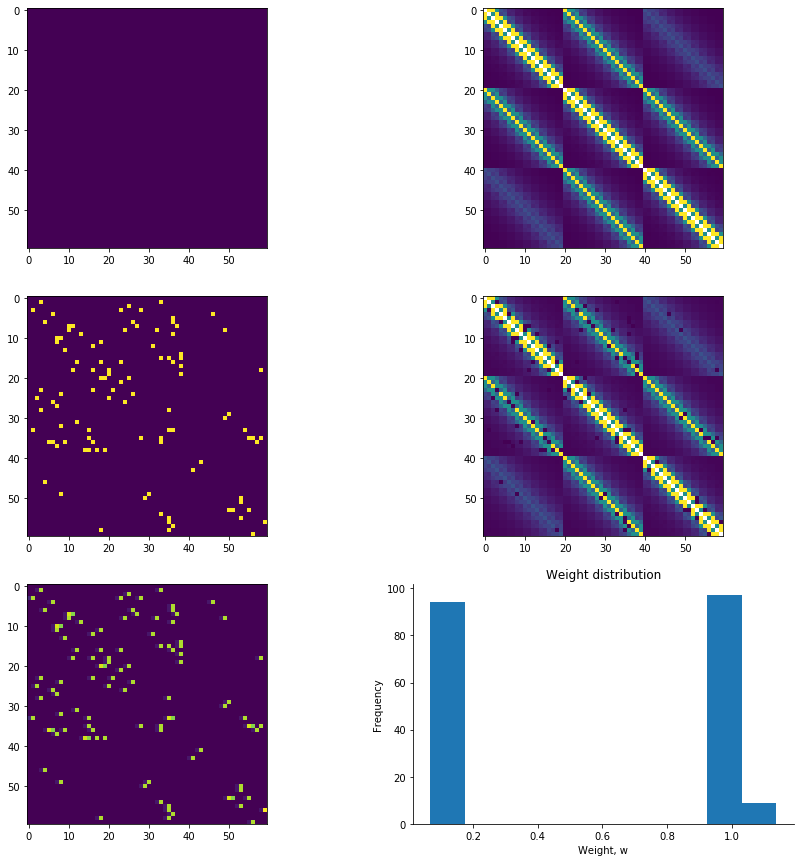

In [28]:
# plot the outcome
plt.figure(figsize=(15,15))
subax1 = plt.subplot(321)
plt.imshow(Aseed)
subax2 = plt.subplot(322)
plt.imshow(Ffseed)
subax3 = plt.subplot(323)
plt.imshow(A)
subax4 = plt.subplot(324)
plt.imshow(Fffinal)
subax5 = plt.subplot(325)
plt.imshow(W)
subax6 = plt.subplot(326)
plt.hist(W[W>0])
plt.xlabel('Weight, w')
plt.ylabel('Frequency')
plt.title('Weight distribution')
subax6.spines['top'].set_visible(False)
subax6.spines['right'].set_visible(False)
# display the number of edges in target and final network as a sanity check
m,np.size(np.where(A.flat))//2 # number of connections